In [ ]:
testing_mode = 0 #0 to run for all subjects, 1 to run for subset
saving_figures = 1 # No=0, Yes=1
server = 1 #running on server(=1) or locally(=0)

# versioning related to hippocampal masks:
version_label = 'v4'
binarization_thresh='50'
version='notebook-05-pattern-similarity_%s_thresh-%s' % (version_label,binarization_thresh)

if testing_mode == 1:
    subject_list = [104,107,108,109,111]
elif testing_mode == 0:
    subject_list = [104,107,108,109,111,112,114,115,120,125,126,127,132,134,135,137,141,
               143,144,146,147,149,150,151,152,153,155,156,161,164,165,170,172,174,175,
               177,178,179,180,182,184,185,187,188]

# excluded from EEG analysis only: 129 (NREM group), 173 (REM group)

# wake subjects: 105,106,110,116,117,119,122,133,139,140,142,145,148,
#                158,159,160,162,166,168,169,176,181,186

n_subjects = len(subject_list)
print('n_subjects:', n_subjects)
print('')

# spindle related
stages = ['stage2', 'SWS']
n_channels = 12
channel_labels = ['F3', 'C3', 'CP1', 'P3', 'Pz', 'CPz', 
                  'Fz', 'F4', 'Cz', 'C4', 'CP2', 'P4']

In [ ]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os
#import os.path
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.io as spio
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
#from statannot import add_stat_annotation
#import plotly.express as px

%matplotlib inline 
%autosave 5

In [ ]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
#print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The seaborn version is {}.'.format(sns.__version__))
print('The pandas version is {}.'.format(pd.__version__))

#assert sklearn.__version__== '0.21.3'
#assert python_version()== '3.7.6'

In [ ]:
# directories
analysis_version = 'manuscript'
if server == 1:
    svd_dir='/jukebox/norman/emcdevitt/studies/SVD/'
else:
    svd_dir='/Volumes/norman/emcdevitt/studies/SVD/'

analysis_dir=svd_dir + 'data/mainanalysis/'
output_dir=analysis_dir + 'output/%s/' % analysis_version
save_figs=analysis_dir + 'figures/%s/notebook-08-sleepdata/' % analysis_version
neuraldata_dir=analysis_dir + 'output/%s/' % version
spindle_dir = svd_dir + 'data/analyzer/'

# make out_dir if it doesn't exist
if os.path.exists(output_dir)==False:
    os.mkdir(output_dir) 
if os.path.exists(save_figs)==False:
    os.mkdir(save_figs) 

print('neural data loaded from: %s' % (neuraldata_dir))
print('')
print('data saved to: %s' % (output_dir))
print('')
print('figures saved to: %s' % (save_figs))

# label dictionaries
conditions = {1:"vio", 2:"nonvio", 3:"vio-nonvio"}
groups = {0:"wake", 1:"NREM", 2:"REM"}
categories = {0:"rest", 1:"face", 2:"scene", 3:"object"}

mask_list=['left_CA2+3+DG_1.5mm', 'right_CA2+3+DG_1.5mm', 'bilateral_CA2+3+DG_1.5mm',
           'left_CA2+3_1.5mm', 'right_CA2+3_1.5mm', 'bilateral_CA2+3_1.5mm',
           'left_DG_1.5mm', 'right_DG_1.5mm', 'bilateral_DG_1.5mm',
           'left_CA1_1.5mm', 'right_CA1_1.5mm', 'bilateral_CA1_1.5mm']

In [ ]:
def main(in_file,sub):
    #print(in_file)
    print (sub+" file exists: "+str(path.exists(in_file)))
def main2(in_file,sub,stage,channel):
    #print(in_file)
    if path.exists(in_file) == False:
        print (sub+" "+stage+" channel "+num2str(channel)+" file does not exist")

print('check that sleep scoring .mat file exists')
for subject in range(0, n_subjects):
    this_sub = int(subject_list[subject])
    sub = 'sub-%s' % (this_sub)
    data_dir=svd_dir + 'data/subjects/%s/eeg/scoring/%s_SVD_LM/' %(sub,this_sub)
    in_file = data_dir + '%s_SVD_LM_stats.mat' % (this_sub)
    if __name__== "__main__":
        main(in_file,sub)
        
print('check that sleep spindle .mat file exists')
for subject in range(0, n_subjects):
    this_sub = int(subject_list[subject])
    sub = 'sub-%s' % (this_sub)
    for stage in stages:
        for chan in range(1,n_channels+1):
            in_file = spindle_dir + 'mat_channel_files_%s/%s_SVD_channel%i.mat' % (stage,this_sub,chan)
            if __name__== "__main2__":
                main2(in_file,sub,stage,chan)

In [ ]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    #data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [ ]:
pd.set_option('display.max_rows', None)

# get subject group info (wake, NREM, REM)
in_file=(analysis_dir + 'subjInfo.mat')
print('loading subject group info from:', in_file)
data = loadmat(in_file)
group_label = data['subjInfo'] #dictionary
group_label_df = pd.DataFrame.from_dict(group_label)
group_label_df

### Sleep Statistics Definitions and Explanations:

- TDT: Total dark time (elapsed time from lights out to lights on).
- SPT: Sleep period time (elapsed time from sleep onset through last epoch of unambiguous sleep [see sleep onset]).
- TST: Total sleep time (duration of time spent in Stages 1, 2, 3, 4 and REM during SPT).
- Total Wake Time: Duration of time awake (within TDT).
- NREM: Duration of time in Stages 1, 2, 3, 4.
- SW: Slow wave sleep (Stages 3, 4).

All sleep stage statistics (and TST) tabulated from within SPT. Extraneous sleep outside of SPT is SBSO (see below).

- Sleep Onset: The time from the epoch of lights out until the first epoch of sleep.
- Wake After Sleep Onset: Wake time after sleep onset during SPT.
- Wake After Final Awakening: Elapsed time spent awake between the final epoch of SPT and lights on.
- Sleep Before Sleep Onset: Any transient sleep occurring between lights off and sleep onset.
- Sleep After Final Onset: Any transient sleep occurring between the final epoch of SPT and lights on.
- All Stage Latencies: Elapsed time to first epoch of specified stage (from either lights off or sleep onset, as specified).
- All Interval Analyeses: Calculated from SPT.

NREM-REM Cycle definitions per Carskadon and Rechtschaffen (2005).

- NREM-REM Cycle: Succession of NREM period of at least 25 minutes duration by a REM period.
- NREM Period: Time interval between first occurance of not REM and the first epoch of the next REM period, subject to combining rule.
- REM Period: Time interval between two consecutive NREM periods or the between the last NREM period and final awakening.
- NREM/REM Segments: Number of uninterrupted periods of NREM/REM during a NREM/REM period.

All other sleep statistics per:

Carskadon, MA, Rechtschaffen, A. Monitoring and Staging Human Sleep. In: Principles and Practices of Sleep Medicine 4th Edition, pgs. 1359-1377. Ed: Kryger, MH, Roth, T, Dement, WC. Philadelphia, PA : Elsevier Saunders, 2005.

In [ ]:
pd.set_option('display.max_rows', 10)
stage_stats_df = pd.DataFrame() #empty dataframe
latencies_df = pd.DataFrame() #empty dataframe

# import sleep scores for each subject
for subject in range(0, len(subject_list)):
    this_sub = int(subject_list[subject])
    sub = 'sub-%s' % (this_sub)
    
    # load scoring .mat file
    data_dir=svd_dir + 'data/subjects/%s/eeg/scoring/%s_SVD_LM/' %(sub,this_sub)
    in_file = data_dir + '%s_SVD_LM_stats.mat' % (this_sub)
    if path.exists(in_file):
        #print('loading subject sleep stage data from:', in_file)
        data = loadmat(in_file)

        # get this subject's sleep/wake group label
        group = []
        group = group_label_df['cond'].loc[group_label_df['id']=='%s' % this_sub]
        group = group.item()

        # sleep stage scores
        select_data = data['stageStats']['percentSleep']
        stage_stats = pd.DataFrame.from_dict(select_data) #convert to dataframe
        stage_stats = stage_stats.rename(columns={0: "Epochs", 1: "Minutes", 2: "percentTDT", 3: "percentSPT", 4: "percentTST"})
        stage_stats.insert(0, "subjectID", this_sub) #insert a column with subjectID
        stage_stats.insert(1, "group", group) #insert a column with sleep condition
        stage_stats.insert(2, "variable", ['TDT', 'SPT', 'TST', 'Sleep before sleep onset', 
                                           'WASO', 'Wake after final awakening', 'Sleep after final awakening', 
                                           'Total wake time', 'S1', 'S2', 'S3', 'S4', 'REM', 'Movement time', 
                                           'NREM', 'SWS', 'Anomalous(Unscored)'])
        stage_stats_df = pd.concat([stage_stats_df, stage_stats], ignore_index=True)
        
        # sleep latencies
        select_data = data['stageStats']['SleepLat']
        latencies = pd.DataFrame.from_dict(select_data) #convert to dataframe
        latencies = latencies.rename(columns={0: "Epochs", 1: "Minutes"})
        latencies.insert(0, "subjectID", this_sub) #insert a column with subjectID
        latencies.insert(1, "group", group) #insert a column with sleep condition
        latencies.insert(2, "variable", ['Lights out to sleep onset', 'Lights out to 10 min continuous sleep', 
                                         'Lights out to S1', 'Light out to S2', 
                                         'Lights out to S3', 'Lights out to S4', 'Lights out to SWS', 
                                         'Lights out to REM', 'Lights out to anomalous(unscored)', 
                                         'Sleep onset to S1', 'Sleep onset to S2', 'Sleep onset to S3', 
                                         'Sleep onset to S4', 'Sleep onset to SWS', 
                                         'Sleep onset to REM'])
        latencies_df = pd.concat([latencies_df, latencies], ignore_index=True)
        
    else:
        print('MISSING SLEEP STAGE DATA FOR:', in_file)
        print('')
    
display(stage_stats_df.head())
display(latencies_df.head())

In [ ]:
# convert proportions to percentages
stage_stats_df['percentTDT'] = stage_stats_df['percentTDT']*100
stage_stats_df['percentSPT'] = stage_stats_df['percentSPT']*100
stage_stats_df['percentTST'] = stage_stats_df['percentTST']*100
display(stage_stats_df.head())

In [ ]:
stage_stats_df.to_csv(output_dir+'sleep_staging_N=%i.csv' %n_subjects)
latencies_df.to_csv(output_dir+'sleep_latencies_N=%i.csv' %n_subjects)

In [ ]:
# make tables showing sleep descriptives
pd.set_option('display.max_rows', None)
df = stage_stats_df.groupby(["group", "variable"]).agg([np.count_nonzero,np.mean, np.std])
df

In [ ]:
# cleanup table
df.drop([('subjectID', 'mean')], axis=1,inplace=True)
df.drop([('subjectID', 'std')], axis=1,inplace=True)
df.drop([('Epochs')], axis=1,inplace=True)
#df.drop([('percentTDT')], axis=1,inplace=True)
df.drop([('percentSPT')], axis=1,inplace=True)
df.drop([('Minutes', 'count_nonzero')], axis=1,inplace=True)
df.drop([('percentTST', 'count_nonzero')], axis=1,inplace=True)
df.drop([('percentTDT', 'count_nonzero')], axis=1,inplace=True)
#df.columns = df.columns.droplevel('Epochs')
display(df)

In [ ]:
# cleanup -- drop some rows
df.drop([('NREM', 'Anomalous(Unscored)')], axis=0,inplace=True)
df.drop([('NREM', 'Movement time')], axis=0,inplace=True)
df.drop([('NREM', 'S4')], axis=0,inplace=True)
df.drop([('NREM', 'SWS')], axis=0,inplace=True)
df.drop([('NREM', 'Sleep after final awakening')], axis=0,inplace=True)
df.drop([('NREM', 'Sleep before sleep onset')], axis=0,inplace=True)
df.drop([('NREM', 'Wake after final awakening')], axis=0,inplace=True)
df.drop([('REM', 'Anomalous(Unscored)')], axis=0,inplace=True)
df.drop([('REM', 'Movement time')], axis=0,inplace=True)
df.drop([('REM', 'S4')], axis=0,inplace=True)
df.drop([('REM', 'SWS')], axis=0,inplace=True)
df.drop([('REM', 'Sleep after final awakening')], axis=0,inplace=True)
df.drop([('REM', 'Sleep before sleep onset')], axis=0,inplace=True)
df.drop([('REM', 'Wake after final awakening')], axis=0,inplace=True)
display(df)
df.to_csv(output_dir+'sleep_staging_bygroup.csv')

In [ ]:
# re-import csv
df=pd.read_csv(output_dir+'sleep_staging_bygroup.csv')
df = df.rename(columns={"Unnamed: 0": "group", "Unnamed: 1": "variable", "subjectID": "n", "Minutes": "minutes(mean)",
                        "Minutes.1": "minutes(std)", "percentTST": "percentTST(mean)", "percentTST.1": "percentTST(std)",
                        "percentTDT": "percentTDT(mean)", "percentTDT.1": "percentTDT(std)"})
df = df.drop([0, 1])
display(df)

In [ ]:
df['minutes(mean)'] = df['minutes(mean)'].astype(float)
df['minutes(std)'] = df['minutes(std)'].astype(float)
df['percentTST(mean)'] = df['percentTST(mean)'].astype(float)
df['percentTST(std)'] = df['percentTST(std)'].astype(float)
df['percentTDT(mean)'] = df['percentTDT(mean)'].astype(float)
df['percentTDT(std)'] = df['percentTDT(std)'].astype(float)
df.dtypes

In [ ]:
df = df.round({"minutes(mean)":2, "minutes(std)":2, "percentTST(mean)":2, 'percentTST(std)':2,
              "percentTDT(mean)":2, 'percentTDT(std)':2}) 
display(df)
df.to_csv(output_dir+'table1_sleep_staging.csv')

## Plotting

In [ ]:
# Seaborn settings
sns.set_style("ticks") #or whitegrid
sns.set_context("paper") #or notebook, poster, talk

#sns.set_palette("Paired")
#sns.color_palette("Paired")

# Create an array with the colors you want to use
#colors = ["#F08080", "#CAE1FF", "#4374B3"]
#two_colors = ["#ca0020", "#0571b0"]
# 
two_colors_blues = ["#6baed6", "#2171b5"]
display(sns.color_palette(two_colors_blues))

In [ ]:
stage_stats_df.head()

In [ ]:
plot_data = stage_stats_df.loc[(stage_stats_df['variable'] == 'TST') | 
                               (stage_stats_df['variable'] == 'S1') |
                               (stage_stats_df['variable'] == 'S2') |
                               (stage_stats_df['variable'] == 'S3') |
                               (stage_stats_df['variable'] == 'REM') |
                               (stage_stats_df['variable'] == 'WASO')]
plot_data.head()

In [ ]:
# for sleep efficiency, we need to move TST as percentage of TDT to the percent TST column
plot_data.loc[plot_data['variable'] == 'TST', 'percentTST'] = plot_data[plot_data['variable'] == 'TST']['percentTDT']
plot_data.head()


REM     132
NREM    132
Name: group, dtype: int64

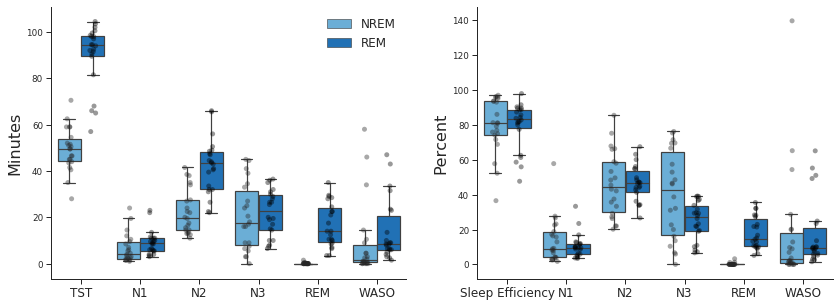

In [85]:
saving_figures = 1
n_subplots = 2
plots=['Minutes', 'percentTST']
variable_order = ['TST','S1', 'S2', 'S3', 'REM', 'WASO']
group_order=['NREM', 'REM']
custom = sns.set_palette(sns.color_palette(two_colors_blues)) #Set custom color palette

f, ax = plt.subplots(1, n_subplots, sharey=False, figsize=(n_subplots*7,5))
for plot in range(0, n_subplots):

    if plot == 0:
        display(plot_data['group'].value_counts())
        
    sns.boxplot(
        data=plot_data, 
        x="variable", order=variable_order,
        y=plots[plot], 
        hue="group", hue_order=group_order,
        palette=custom, ax=ax[plot],
        showfliers = False,
        saturation=1
        )
    
    sns.stripplot(
        data=plot_data, 
        x="variable", order=variable_order,
        y=plots[plot], 
        hue="group", hue_order=group_order,
        color='black', alpha=0.4, dodge=True, zorder=8, ax=ax[plot]
    )
    
    #plt.axhline(y=0, linewidth=4, color='black', zorder=1) 
    #ax[plot].set(ylim=(-.0275, .0275))
    if plot == 0:
        ax[plot].set_ylabel("Minutes", fontsize=16)
        #ax[plot].set_xticklabels(variable_order,fontsize=12)
        ax[plot].set_xticklabels(['TST','N1','N2','N3','REM','WASO'],fontsize=12)
    else:         
        ax[plot].set_ylabel("Percent", fontsize=16)
        ax[plot].set_xticklabels(['Sleep Efficiency','N1','N2','N3','REM','WASO'],fontsize=12)
        
    ax[plot].set(xlabel=None)
    #ax[plot].set_title(plot_title, fontsize=12)
    if plot == 0:
        h, l = ax[plot].get_legend_handles_labels()
        ax[plot].legend(h, ['NREM', 'REM'], frameon=False, loc='upper right', fontsize=12)
    else:
        ax[plot].legend().remove()
# final touches
sns.despine()
plt.show()

# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'sleep_staging_boxplot.png', format='png', dpi=500)

## Load spindle data

In [ ]:
# Setup dictionaries
spindle_num={'subjectID': [], 'group': [], 'stage': [],
            'channel': [], 'channel_label': [], 'spindle_num': []}

In [ ]:
pd.set_option('display.max_rows', 10)

# import spindles for each subject, each stage, each channel
for subject in range(0, len(subject_list)):
    this_sub = int(subject_list[subject])
    sub = 'sub-%s' % (this_sub)
    for stage in stages:
        for chan in range(1,n_channels+1):
            label = channel_labels[chan-1] #zero indexing
            in_file = spindle_dir + 'mat_channel_files_%s/%s_SVD_channel%i.mat' % (stage,this_sub,chan)
            if path.exists(in_file):
                data = loadmat(in_file) #locs2, number_spindles
                
                # get this subject's sleep/wake group label
                group = []
                group = group_label_df['cond'].loc[group_label_df['id']=='%s' % this_sub]
                group = group.item()

                # spindle number
                select_data = data['number_spindles']
                #print(this_sub, group, stage, chan, select_data)
                spindle_num['subjectID'].append(this_sub)
                spindle_num['group'].append(group)
                spindle_num['stage'].append(stage)
                spindle_num['channel'].append(chan)
                spindle_num['channel_label'].append(label)
                spindle_num['spindle_num'].append(select_data)
            else:
                print('Missing sleep spindle data for:', in_file)
                # Note: subject 185 did not have any SWS

In [ ]:
spindle_df = pd.DataFrame.from_dict(spindle_num)
spindle_df

In [ ]:
# calculate spindle density
s2_s3_min = stage_stats_df[(stage_stats_df['variable'] == 'S2') | (stage_stats_df['variable'] == 'S3')]
s2_s3_min = s2_s3_min[['subjectID', 'group', 'variable', 'Minutes']]
s2_s3_min = s2_s3_min.rename(columns={"variable": "stage"})
s2_s3_min = s2_s3_min.replace({'stage': {'S2': 'stage2', 'S3': 'SWS'}})
#display(s2_s3_min)

spindle_df = pd.merge(spindle_df, s2_s3_min, on =['subjectID', 'group', 'stage'])
spindle_df['spindle_density'] = spindle_df['spindle_num']/spindle_df['Minutes']
display(spindle_df)
spindle_df.to_csv(output_dir+'spindle_data_allchannels_N=%s.csv' %n_subjects)

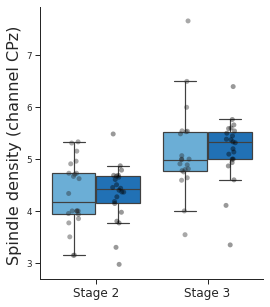

In [88]:
saving_figures = 1
stage_order=['stage2', 'SWS']
depVar = "spindle_density"
group_order=['NREM', 'REM']
channel="CPz"
custom = sns.set_palette(sns.color_palette(two_colors_blues)) #Set custom color palette


plot_data = spindle_df.loc[(spindle_df['channel_label'] == channel)]

n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*4,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="stage", order=stage_order,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.stripplot(
    data=plot_data, 
    x="stage", order=stage_order,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

# ax.set(ylim=(-.02, .02))
#ax.set_title(plot_title, fontsize=12)
ax.legend().remove()
#h, l = ax.get_legend_handles_labels()
#ax.legend(h[0:2], ['NREM', 'REM'], frameon=False, loc='upper right') #bbox_to_anchor=(1, 1)

# final touches
sns.despine()
ax.set(xlabel=None)
#ax.set(ylabel="Spindle density (channel CPz)", fontsize=16)
ax.set_ylabel("Spindle density (channel CPz) ", fontsize=16)
#ax.set(xticklabels=['Stage 2', 'Stage 3'], fontsize=12)
ax.set_xticklabels(['Stage 2','Stage 3'],fontsize=12)
#ax.set(xticks=[])
plt.show()

# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'spindle_density_boxplot.png', format='png', dpi=500)

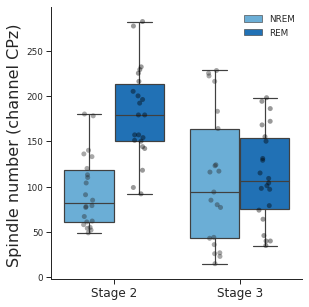

In [89]:
saving_figures = 1
stage_order=['stage2', 'SWS']
depVar = "spindle_num"
group_order=['NREM', 'REM']
channel="CPz"
custom = sns.set_palette(sns.color_palette(two_colors_blues)) #Set custom color palette

plot_data = spindle_df.loc[(spindle_df['channel_label'] == channel)]

n_subplots = 1
f, ax = plt.subplots(1, n_subplots, sharey=True, figsize=(n_subplots*4.5,5)) #figsize=(10,5)

sns.boxplot(
    data=plot_data, 
    x="stage", order=stage_order,
    y=depVar, 
    hue="group", hue_order=group_order, 
    #ci=95, n_boot=5000, seed=10,  errwidth=1, capsize=0.05, errcolor='black',
    palette=custom, showfliers=False, saturation=1, zorder=5
    )

sns.stripplot(
    data=plot_data, 
    x="stage", order=stage_order,
    y=depVar, 
    hue="group", hue_order=group_order,
    color='black', alpha=0.4, dodge=True, zorder=8  #ax=ax[plot] #ax=ax[plot_coord[plot]]
    )

# ax.set(ylim=(-.02, .02))
#ax.set_title(plot_title, fontsize=12)
#ax.legend().remove()
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], ['NREM', 'REM'], frameon=False, loc='upper right') #bbox_to_anchor=(1, 1)

# final touches
sns.despine()
ax.set(xlabel=None)
ax.set_ylabel("Spindle number (channel CPz) ", fontsize=16)
ax.set_xticklabels(['Stage 2','Stage 3'],fontsize=12)
#ax.set(xticks=[])
plt.show()

# Save figure
if saving_figures == 1:
    f.savefig(save_figs + 'spindle_number_boxplot.png', format='png', dpi=500)